# Best Neighborhood in Pittsburgh
## By Aoxue Ding, Jared Glickfield, and Jackson Lustina 

We all looked at three differnt metric: polling locations, parks, and covid cases. These three topics give a good array of current factors to see which neightborhood is the best today.

Each person has their own notebook explaining their work and this is the combined metric

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### Importing General Files

In [42]:
neighborhood = gpd.read_file("Neighborhoods_.geojson")
neighborhoodCopy = neighborhood.copy()

#### Getting Park data into df

In [43]:
parks = gpd.read_file("jbg53Files/Pittsburgh_Parks.geojson")
parkNum = pd.DataFrame(neighborhood.objectid, columns=['objectid', 'parks'])
for index, n in neighborhood.iterrows():
    numOfParks = 0 
    for index, p in parks.iterrows():
        if n.geometry.intersects(p.geometry):
            numOfParks += 1
            parks.drop([index])
    parkNum.at[parkNum[parkNum['objectid'] == n.objectid].index.values[0], 'parks'] = numOfParks

neighborhood.insert(1, 'parks', parkNum.parks)

#### Getting Cases data into df

In [44]:
d3 = pd.read_csv("Covid-19 Analysis/3.csv")
num_cases = d3.groupby("neighborhood_municipality").sum()['cases']

In [45]:
neighborhood['hood'] = neighborhood['hood'] + ' (Pittsburgh)'
neighborhood = neighborhood.merge(num_cases, how='left', left_on='hood', right_on='neighborhood_municipality')

In [46]:
neighborhood['hood'] = neighborhoodCopy['hood']

#### Getting Polling data into df

In [47]:
poll = gpd.read_file("jcl109Files/Polling.geojson")
pollNum = pd.DataFrame(neighborhood.objectid , columns = ['objectid','polling'])
for index, n in neighborhood.iterrows():
    numOfPolls = 0
    for index, p in poll.iterrows():
        if n.geometry.intersects(p.geometry):
             numOfPolls +=1
    pollNum.at[pollNum[pollNum['objectid'] == n.objectid].index.values[0],'polling'] = numOfPolls
neighborhood.insert(1 ,'polling', pollNum.polling)

In [48]:
neighborhood_ = neighborhood

#### Metric Calculation
We want final metric to run from 0 to 1 so we set a percentage for each metric 
parks are worth .2, cases are work .5 and polling locations are worth .3

We then map using np.interp all values from 0 to 1

Then we do some math and we get this

In [70]:
neighborhood = neighborhood[['hood', 'parks', 'cases', 'polling', 'geometry']]
neighborhood.insert(1 ,'metric', np.nan)
neighborhood.parks = np.interp(neighborhood.parks, [0, neighborhood.parks.max()], [0,1])
neighborhood.cases = np.interp(neighborhood.cases, [0, neighborhood.cases.max()], [0,1])
neighborhood.cases = 1 - neighborhood.cases
neighborhood.cases = neighborhood.cases.fillna(.5)
neighborhood.polling = np.interp(neighborhood.polling, [0, neighborhood.polling.max()], [0,1])

neighborhood.metric = .2 * neighborhood.parks + .5 * neighborhood.cases + .3 * neighborhood.polling

In [81]:
neighborhood = neighborhood.sort_values('metric', ascending = False)
neighborhood

,hood,metric,parks,cases,polling,geometry,center
53,Point Breeze,0.706266,0.833333,0.869198,0.35,"POLYGON ((-79.89319 40.44649, -79.89391 40.443...",POINT (-79.90765 40.44571)
78,Beechview,0.659072,0.583333,0.784810,0.50,"POLYGON ((-80.02121 40.42342, -80.02111 40.423...",POINT (-80.02458 40.41263)
35,East Liberty,0.655886,0.916667,0.675105,0.45,"POLYGON ((-79.91580 40.46081, -79.91577 40.460...",POINT (-79.92461 40.46467)
8,Troy Hill,0.609367,0.500000,0.898734,0.20,"MULTIPOLYGON (((-79.97766 40.46653, -79.97771 ...",POINT (-79.98300 40.46280)
47,Hazelwood,0.608186,0.500000,0.776371,0.40,"POLYGON ((-79.95505 40.42713, -79.95498 40.427...",POINT (-79.94114 40.41238)
...,...,...,...,...,...,...,...
76,Carrick,0.424093,0.250000,0.388186,0.60,"POLYGON ((-79.99194 40.40719, -79.99191 40.407...",POINT (-79.98605 40.39496)
59,Glen Hazel,0.331245,0.083333,0.599156,0.05,"POLYGON ((-79.92030 40.41205, -79.92027 40.412...",POINT (-79.93044 40.40601)
31,Shadyside,0.323734,0.166667,0.130802,0.75,"POLYGON ((-79.92238 40.46055, -79.92208 40.460...",POINT (-79.93233 40.45349)
46,Bluff,0.286941,0.083333,0.510549,0.05,"POLYGON ((-79.99390 40.43893, -79.99381 40.438...",POINT (-79.98495 40.43635)


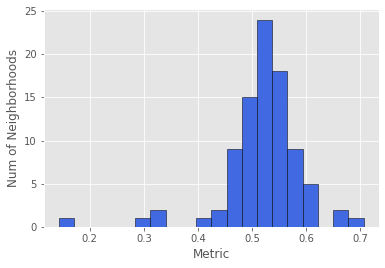

In [97]:
fig, ax = plt.subplots()
ax.set_ylabel('Num of Neighborhoods')
ax.set_xlabel('Metric')
plt.style.use('ggplot')
plt.hist(neighborhood.metric, bins = 20, edgecolor = 'k', color = 'royalblue')
plt.show()

#### Map

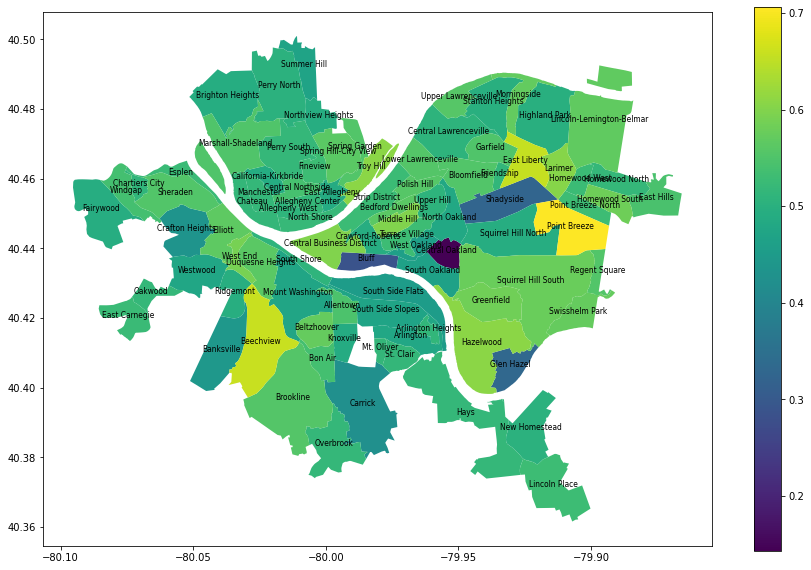

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))

neighborhood['center'] = neighborhood.geometry.centroid

neighborhoodPts = neighborhood.copy()
neighborhoodPts.set_geometry("center", inplace = True)

for x, y, label in zip(neighborhoodPts.geometry.x, neighborhoodPts.geometry.y, neighborhood.hood):
    plt.text(x, y, label, fontsize = 7.5, ha = 'center', weight = '525')
    
neighborhood.plot(column='metric', ax=ax, legend=True)

### What is the best?

In [90]:
neighborhood[['hood', 'metric']].head(10)

,hood,metric
53,Point Breeze,0.706266
78,Beechview,0.659072
35,East Liberty,0.655886
8,Troy Hill,0.609367
47,Hazelwood,0.608186
28,Larimer,0.603924
41,Central Business District,0.599430
43,Middle Hill,0.598924
89,West End,0.590338
49,Greenfield,0.583987


### The worst?

In [88]:
neighborhood[['hood', 'metric']].tail(5)

,hood,metric
76,Carrick,0.424093
59,Glen Hazel,0.331245
31,Shadyside,0.323734
46,Bluff,0.286941
36,Central Oakland,0.143333
